深度学习的框架通过自动计算导数，自动微分来求导automatic differentiation。系统会根据设计好的模型构建一个计算图，来跟踪计算数据和操作组合方式，并产生输出。自动微分系统能够反向传播梯度，跟踪整个计算图，填充每个参数的偏导数。

### 标量对向量的反向传播
想对$y=2x^Tx$关于列向量x求导     
1. 创建x并分配一个初始值
2. 预设一个地方来存储梯度，不会对每个参数求导分配新的内存，y对x的梯度          
**注意：一个标量函数关于向量x的梯度是向量，与x具有相同形状**
3. 通过反向传播自动计算y关于x每个分量的梯度 调用y.backward()
4. pytorch会累积梯度，因此每循环一次要清零，调用x.grad.zero_()或者x.zero_grad()

In [1]:
import torch

In [2]:
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [3]:
x.requires_grad_(True)# 等价于x=torch.arange(4.0,requires_grad=True)
x.grad

In [4]:
y=2*torch.dot(x,x)
y

tensor(28., grad_fn=<MulBackward0>)

In [5]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [6]:
x.grad==4*x

tensor([True, True, True, True])

In [9]:
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

### 非标量变量的反向传播
向量y对于向量x的导数为一个矩阵，计算损失函数的导数，不是计算微分矩阵，单独计算批量中每个样本的偏导数之和      
**按照例子来看的话，也得把y变成一个标量然后再进行求导**

In [13]:
x.grad.zero_()
y=x*x
y.sum().backward()
# print(y)
x.grad

tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)


tensor([0., 2., 4., 6.])

### 分离计算
y作为x函数计算，z作为y和x函数计算，但要将y试做一个常数，因此要对y进行计算图分离，调用y.detach()。      
y分离返回一个新变量u，该变量与y有相同的值，梯度不会向后流经u到x，反向传播计算z=u*x关于x的偏导数，将u作为常数处理

In [45]:
x.grad.zero_()
y = x*x
u = y.detach()
print(u)
z = u*x

z.sum().backward()   #把u看成常数
x.grad

tensor([0., 1., 4., 9.])


tensor([0., 1., 4., 9.])

In [46]:
x.grad.zero_()
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

### python控制流的梯度计算
自动微分的好处，构建函数计算图通过python的操作（条件，循环或者任意函数调用）运算，仍然可以得到变量的梯度

In [58]:
def f(a):
    b = a*2
    while b.norm()<1000:
        b=b*2
    if b.sum()>0:
        c=b
    else:
        c=100*b
    return c

In [59]:
a = torch.randn(size=(),requires_grad=True)
d = f(a)
d.backward()

In [60]:
a.grad

tensor(2048.)

In [61]:
d/a

tensor(2048., grad_fn=<DivBackward0>)

### 练习
1. 为什么计算⼆阶导数⽐⼀阶导数的开销要更⼤？
2. 在运⾏反向传播函数之后，⽴即再次运⾏它，看看会发⽣什么。
3. 在控制流的例⼦中，我们计算d关于a的导数，如果将变量a更改为随机向量或矩阵，会发⽣什么？
4. 重新设计⼀个求控制流梯度的例⼦，运⾏并分析结果。
5. 使f(x) = sin(x)，绘制f(x)和df(x)
dx 的图像，其中后者不使⽤f
′
(x) = cos(x)。

1. 为什么计算⼆阶导数⽐⼀阶导数的开销要更⼤？   
因为二阶导数是在一阶导数运算的基础上进行的，所以二阶必然比一阶开销要大

2. 在运⾏反向传播函数之后，⽴即再次运⾏它，看看会发⽣什么。     
会报错，前向过程建立计算图，反向传播后释放。计算图的中间结果已经被释放，第二次反向传播就会出错，因此在backward函数中加上retain_graph=True，就能再次反向传播了

3. 在控制流的例⼦中，我们计算d关于a的导数，如果将变量a更改为随机向量或矩阵，会发⽣什么？     
会发生错误，因为pytorch中不让张量对张量进行求导，都要变成标量后才能进行求导的。如果对一个非标量调用backward的话，需要传入一个gradient参数

4. 重新设计⼀个求控制流梯度的例⼦，运⾏并分析结果。     

In [84]:
def f(a):
    print(a.norm())
    if a.norm()>10:
        b=a
    else:
        b=3*a
    return b.sum()
    

In [85]:
a = torch.tensor([1.0,2.0,3.0,4.0,5.0], requires_grad=True)
d = f(a)
d.backward()


tensor(7.4162, grad_fn=<NormBackward0>)


In [83]:
a.grad

tensor([3., 3., 3., 3., 3.])

In [80]:
d/a

tensor([45.0000, 22.5000, 15.0000, 11.2500,  9.0000], grad_fn=<DivBackward0>)

5. 使f(x) = sin(x)，绘制f(x)和df(x)/dx 的图像，其中后者不使⽤f′(x) = cos(x)。

In [86]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [93]:
x=np.arange(-5,5,0.01)
f = np.sin(x)
# df=[]
# for i in x:
#     v=torch.tensor(i,requires_grad=True)
#     y = torch.sin(v)
#     y.backward()
#     df.append(v.grad)


In [91]:
df

[tensor(0.2837),
 tensor(0.2741),
 tensor(0.2644),
 tensor(0.2548),
 tensor(0.2451),
 tensor(0.2354),
 tensor(0.2257),
 tensor(0.2159),
 tensor(0.2061),
 tensor(0.1963),
 tensor(0.1865),
 tensor(0.1767),
 tensor(0.1668),
 tensor(0.1570),
 tensor(0.1471),
 tensor(0.1372),
 tensor(0.1273),
 tensor(0.1173),
 tensor(0.1074),
 tensor(0.0975),
 tensor(0.0875),
 tensor(0.0775),
 tensor(0.0676),
 tensor(0.0576),
 tensor(0.0476),
 tensor(0.0376),
 tensor(0.0276),
 tensor(0.0176),
 tensor(0.0076),
 tensor(-0.0024),
 tensor(-0.0124),
 tensor(-0.0224),
 tensor(-0.0324),
 tensor(-0.0424),
 tensor(-0.0524),
 tensor(-0.0623),
 tensor(-0.0723),
 tensor(-0.0823),
 tensor(-0.0923),
 tensor(-0.1022),
 tensor(-0.1122),
 tensor(-0.1221),
 tensor(-0.1320),
 tensor(-0.1419),
 tensor(-0.1518),
 tensor(-0.1617),
 tensor(-0.1715),
 tensor(-0.1814),
 tensor(-0.1912),
 tensor(-0.2010),
 tensor(-0.2108),
 tensor(-0.2206),
 tensor(-0.2303),
 tensor(-0.2400),
 tensor(-0.2497),
 tensor(-0.2594),
 tensor(-0.2690),
 te

In [94]:
v=torch.tensor(x,requires_grad=True)
y = torch.sin(v)
y.sum().backward()
df = v.grad.numpy()

In [96]:
df

array([ 2.83662185e-01,  2.74058920e-01,  2.64428248e-01,  2.54771134e-01,
        2.45088543e-01,  2.35381443e-01,  2.25650805e-01,  2.15897603e-01,
        2.06122811e-01,  1.96327406e-01,  1.86512369e-01,  1.76678681e-01,
        1.66827326e-01,  1.56959288e-01,  1.47075554e-01,  1.37177112e-01,
        1.27264953e-01,  1.17340068e-01,  1.07403448e-01,  9.74560886e-02,
        8.74989834e-02,  7.75331285e-02,  6.75595202e-02,  5.75791561e-02,
        4.75930341e-02,  3.76021529e-02,  2.76075115e-02,  1.76101093e-02,
        7.61094613e-03, -2.38897811e-03, -1.23886635e-02, -2.23871100e-02,
       -3.23833178e-02, -4.23762873e-02, -5.23650192e-02, -6.23485146e-02,
       -7.23257753e-02, -8.22958034e-02, -9.22576020e-02, -1.02210175e-01,
       -1.12152527e-01, -1.22083664e-01, -1.32002592e-01, -1.41908321e-01,
       -1.51799858e-01, -1.61676216e-01, -1.71536407e-01, -1.81379444e-01,
       -1.91204343e-01, -2.01010121e-01, -2.10795799e-01, -2.20560398e-01,
       -2.30302941e-01, -

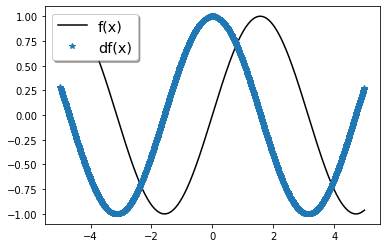

In [97]:
fig,ax = plt.subplots()
ax.plot(x,f,'k',label='f(x)')
ax.plot(x,df,'*',label='df(x)')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')